# 0. 기본 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.set(font="Malgun Gothic")
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# 데이터 분할 및 평가 지표

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

# RandomForest 라이브러리

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# 파라미터 튜닝 함수

In [4]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import optuna

# 빈도테이블 생성

In [5]:
def count(x):
    data1=pd.DataFrame(x.value_counts()).reset_index()
    data1.columns=['category','빈도수']
    return data1

# Barplot 생성

In [6]:
def bargraph(x,y,x_label,y_label,figsize1,figsize2,data):
    plt.figure(figsize=(figsize1, figsize2))
    if data[x].dtypes=='int64':
        data[x]=data[x].astype('str')
    data=data.sort_values(by=y,ascending=False).reset_index()
    
    for index, row in data.iterrows():
        g=sns.barplot(x,y,data=data)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        g.text(index,row[y],row[y],color='black',ha='center')

# 성능 지표 추출

In [7]:
# 성능지표 추출
def Evaluation_metric(actual,pred):
    print(f'MAE: {round(mean_absolute_error(actual,pred),2)}')
    print(f'MSE: {round(mean_squared_error(actual,pred),2)}')
    print(f'RMSE: {round(sqrt(mean_squared_error(actual,pred)),2)}')
    print(f'RMSPE: {round(sqrt(mean_squared_error(actual,pred))/np.mean(actual)*100,2)}%')

# 1. 시드 고정

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# 2. 데이터 불러오기

In [9]:
# Train, Valid, Test Split용 데이터
data=pd.read_csv(os.listdir()[9],encoding='EUC-KR')
# 지표 확인용 데이터
data_real=pd.read_csv(os.listdir()[9],encoding='EUC-KR')
# 배정신청인원 0명 제거
data=data.query('합계!=0')
#필요 컬럼 추출
selected_columns_1=['구분','합계', '작물 종류','농지면적(실제경작)','전년대비농경체증감률','고령농경체비율','전년도이탈인원','전년도활용여부']
selected_columns_2=['비고', '지자체명_시도', '지자체명_시군구', '구분', '농업경영체','합계', '작물 종류','농지면적(실제경작)','전년대비농경체증감률','고령농경체비율','전년도이탈인원','전년도활용여부'] #원본 데이터 컬럼
data=data[selected_columns_1]
data_real=data_real[selected_columns_2]
# 농지면적(실제경작) 컬럼명 변경
data.rename(columns={'농지면적(실제경작)':'농지면적','작물 종류':'작물종류'},inplace=True)

# 이상치 제거: 농지 면적, 합계

In [10]:
data=data.query('0.04<농지면적<2.5')
data=data.query('합계<11')

# 데이터 분할 Train, Valid, Test

In [11]:
# 작물 종류 기준 층화 추출 Train Test 비율 8:2
X=data.drop(columns=['합계']) #독립변수 Set
Y=data['합계'] #Target 변수 set

# Train, Test 분할
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,stratify=X['작물종류'],random_state=42)

# 2차 Train, Validation 분할
X_train, X_valid, Y_train, Y_valid=train_test_split(X_train,Y_train,test_size=0.2,stratify=X_train['작물종류'],random_state=42)

# 연속형 변수 정규화 & 범주형 변수 라벨 인코딩 진행

In [12]:
# 연속형 변수 정규화
min_max_scaler=MinMaxScaler()
for i in X_train.columns:
    if (X_train[i].dtypes!='object'):
        X_train[i]=min_max_scaler.fit_transform(X_train[[i]])
        X_valid[i]=min_max_scaler.transform(X_valid[[i]])
        X_test[i]=min_max_scaler.transform(X_test[[i]])
    else:
        pass

In [13]:
# 범주형 변수 라벨 인코딩
label_encoder=LabelEncoder()
for i in X_train.columns:
    if X_train[i].dtypes=='object':
        X_train[i]=label_encoder.fit_transform(X_train[i])
        X_valid[i]=label_encoder.transform(X_valid[i])
        X_test[i]=label_encoder.transform(X_test[i])
    else:
        pass

# RandomForest Regressor parameter Tuning

- 주요 파라미터 설명

- n_estimators=의사 결정 트리 개수

- max_depth= 트리 최대 깊이

- min_sample_split=최소한의 샘플 수

- min_sample_leaf=리프 노드가 되기 위한 최소 샘플 수

- max_feature= 각 노드에서 분할에 사용할 특성의 최대 개수
-------------------------------------------------------------------------------------------------------------


- 초기 파라미터

- model_reg=RandomForestRegressor(n_jobs=-1,random_state=42,n_estimators=200,max_depth=8)

-------------------------------------------------------------------------------------------------------------

- 파라미터 튜닝

- max_depth 6~9

- 반복수 100~300

# 초기 기본 모델

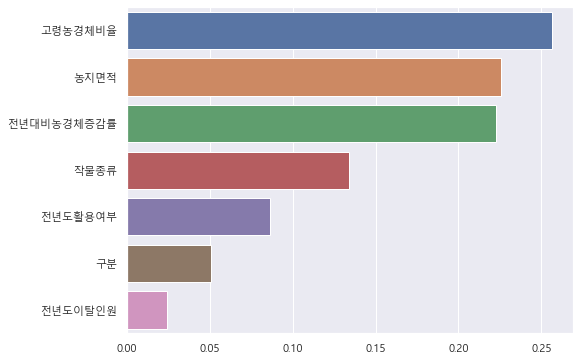

MAE: 1.36
MSE: 3.33
RMSE: 1.83
RMSPE: 54.09%
----------------------------------------------------------------------------------------------------
MAE: 12.41
MSE: 352.9
RMSE: 18.79
RMSPE: 22.93%


In [17]:
# Randomforest 모델 구축
model_reg=RandomForestRegressor(n_jobs=-1,random_state=42,n_estimators=200,max_depth=8)
model_reg.fit(X_train,Y_train)
value_importance=model_reg.feature_importances_
value_importance=pd.Series(value_importance,index=X_train.columns)
value_importance=value_importance.sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=value_importance,y=value_importance.index)
plt.show()
pred=model_reg.predict(X_test)
pred=pd.DataFrame(pred,columns=['예측값'])
pred['예측값']=round(pred['예측값'],0)
Evaluation_metric(Y_test,pred=pred)
print('-'*100)
# Test data Set
test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
data_test['predict']=pred
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()
result_1=result.query('합계>10')
Evaluation_metric(result_1['합계'],pred=result_1['predict'])

# OPTUNA 라이브러리 활용 파라미터 튜닝

파라미터 튜닝 코드

- optuna.trial.Trial.suggest_categorical() : 리스트 범위 내에서 값을 선택한다.
- optuna.trial.Trial.suggest_int() : 범위 내에서 정수형 값을 선택한다.
- optuna.trial.Trial.suggest_float() : 범위 내에서 소수형 값을 선택한다.
- optuna.trial.Trial.suggest_uniform() : 범위 내에서 균일분포 값을 선택한다.
- optuna.trial.Trial.suggest_discrete_uniform() : 범위 내에서 이산 균일분포 값을 선택한다.
- optuna.trial.Trial.suggest_loguniform() : 범위 내에서 로그 함수 값을 선택한다.

In [33]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 400),
        'criterion': 'mse',
        'max_depth' : trial.suggest_int('max_depth', 9, 12),
        'min_samples_split': trial.suggest_int('min_samples_split', 11, 13),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 5),
        'min_weight_fraction_leaf': 0.0,
        'max_features': trial.suggest_int('max_features', 1, 3),
        'max_leaf_nodes': None,
        'min_impurity_decrease': 0.0,
        'bootstrap': True,
        'n_jobs': -1,
        'random_state': 42
    }
    # 학습 모델 생성
    model_reg=RandomForestRegressor(**params)
    
    #트레인 셋 학습
    model_reg.fit(X_train,Y_train)
    
    #검증 데이터 셋으로 모델 검증
    score = mean_absolute_error(model_reg.predict(X_valid), Y_valid)
    return score

study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
# 최적화된 파라미터 값 확인
best_params = study.best_params
print(best_params)
#모델 검증
model_reg = RandomForestRegressor(**best_params)
model_reg.fit(X_train,Y_train)

#예측값 
pred=model_reg.predict(X_test)
# 인원 수 예측이기에 예측된 결과에 반올림 적용
pred=pd.DataFrame(pred,columns=['예측값'])
#반올림
pred['예측값']=round(pred['예측값'],0)
#평가지표
print('농업경영체별 평가지표 결과')
Evaluation_metric(Y_test,pred=pred)
print('-'*100)

test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
#예측값
data_test['predict']=pred
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()
result_1=result.query('합계>10')
print('배정신청인원 10명 이상 시군구 단위 평가지표')
Evaluation_metric(result_1['합계'],pred=result_1['predict'])

[I 2023-11-27 17:34:56,209] A new study created in memory with name: no-name-9de51089-9622-4de3-8700-eb679f8b9bd0
[I 2023-11-27 17:34:56,612] Trial 0 finished with value: 1.4038189643644314 and parameters: {'n_estimators': 334, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 2}. Best is trial 0 with value: 1.4038189643644314.
[I 2023-11-27 17:34:57,019] Trial 1 finished with value: 1.3880551382490693 and parameters: {'n_estimators': 324, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 3}. Best is trial 1 with value: 1.3880551382490693.
[I 2023-11-27 17:34:57,502] Trial 2 finished with value: 1.3992377014450559 and parameters: {'n_estimators': 397, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 3}. Best is trial 1 with value: 1.3880551382490693.
[I 2023-11-27 17:34:57,924] Trial 3 finished with value: 1.4220847370529734 and parameters: {'n_estimators': 391, 'max_depth': 10, 'min_samples_sp

{'n_estimators': 359, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 3}
농업경영체별 평가지표 결과
MAE: 1.33
MSE: 3.21
RMSE: 1.79
RMSPE: 53.06%
----------------------------------------------------------------------------------------------------
배정신청인원 10명 이상 시군구 단위 평가지표
MAE: 11.55
MSE: 285.04
RMSE: 16.88
RMSPE: 20.61%
